### pip install matplotlib==3.2

In [2]:
%matplotlib inline

import numpy as np
import time
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import XTC, GRO
import MDAnalysis.analysis.rms
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
import glob
print(MDAnalysis.__version__)

2.1.0


In [3]:
#####-------100ns------#####
alpha_start = 107
alpha_end = 125
actloop_start = 208
actloop_end = 233
#############################

In [ ]:
start = time.time()
active_ref1 = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_active_CA.pdb'
inactive_ref1 = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_inactive_CA.pdb'
active_ref = mda.Universe(active_ref1)
inactive_ref = mda.Universe(inactive_ref1)

var_xtc = []
for i in range(0,10): # number of trajectory files
    myPath = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/traj_curr/traj_wt/'
    tifCounter = len(glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc"))
    for j in range(0,tifCounter):
        var_xtc.append( myPath + 'trajectories_'+str(i) +'/' +glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc")[j])

    
################################################################################################################ 
################################################################################################################
var_gro = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/active_mek_wt_protein.gro' 
u = mda.Universe(var_gro, var_xtc[34])


In [ ]:
len(var_xtc)

In [ ]:
len(u.trajectory)

In [ ]:
with open('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/fes_8us_wt_mintozero.dat') as f:
    
    lines = f.readlines()
        
#lines = lines[9:2659]
new_lines = []    
# Get rid of empty lines
for line in lines:
    # Strip whitespace, should leave nothing if empty line was just "\n"
    if not line.strip():
        continue
    # We got something, save it
    else:
        new_lines.append(line)
        
lines = new_lines[9:]
    
bin_size_active = 201 # This was set in the PLUMED simulation
bin_size_inactive = 201
x = []
y1 = [] # stores the active coordinates
y2 = [] # stores the inactive coordinates
z1 = [] # stores the free energy value

for i in range(0,len(lines)):
    
    words = lines[i].split()
    int_lst = [float(x) for x in words]
   
    y1.append(int_lst[0]) #y1 takes in active rmsd coordinates
    y2.append(int_lst[1]) #y2 takes in inactive rmsd coordinates
    z1.append(int_lst[2]) #z1 takes in free energy

    
#y1 = y1[0:bin_size_active]
#y2 = y2[0:len(lines):bin_size_active]

y1 = [round(num, 2) for num in y1]
y2 = [round(num, 2) for num in y2]
z1 = [round(num, 2) for num in z1]



In [ ]:
start_time = time.time()
print (len(u.trajectory))
end_time = time.time()


In [ ]:
t = end_time - start_time
t

In [ ]:
# rmsd calculate frame wise
start_time = time.time()
rmsd_active = np.zeros(len(u.trajectory))
rmsd_inactive = np.zeros(len(u.trajectory))

for j in range(0,len(u.trajectory)):
    u.trajectory[j]

    align.alignto(u, inactive_ref, select="protein and not(resid {}:{}) and not(resid {}:{})  and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end), weights="mass")

    a1helixloopi  = inactive_ref.select_atoms("(resid {}:{} or resid {}:{}) and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a1CAhelixloopi  = a1helixloopi.positions

    a2helixloopi   = u.select_atoms("(resid {}:{} or resid {}:{}) and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a2CAhelixloopi  = a2helixloopi.positions


    rmsd_inactive[j] = rmsd(a1CAhelixloopi, a2CAhelixloopi)


    align.alignto(u, active_ref, select="protein and not(resid {}:{}) and not(resid {}:{})  and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end), weights="mass")

    a1helixloopa  = active_ref.select_atoms("(resid {}:{} or resid {}:{}) and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a1CAhelixloopa  = a1helixloopa.positions

    a2helixloopa   = u.select_atoms("(resid {}:{} or resid {}:{}) and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a2CAhelixloopa  = a2helixloopa.positions

    rmsd_active[j] = rmsd(a1CAhelixloopa, a2CAhelixloopa)

# to round up
rmsd_active = [round(num, 2) for num in rmsd_active]
rmsd_inactive = [round(num, 2) for num in rmsd_inactive]

end_time = time.time()
t = end_time - start_time
print(t)

In [ ]:
def free(rmsd_act,rmsd_inact,y1,y2,z1):
    d = np.zeros(len(y1))
    for i in range(0,len(y1)):
        d[i] = ((y1[i] - rmsd_act)**(2) + (y2[i] - rmsd_inact)**(2))**(0.5)
    ind = np.argmin(d)
    return(z1[ind])

In [ ]:
# compute the partition function
start_time = time.time()
partition_func = np.zeros(len(u.trajectory))
for i in range (0,len(u.trajectory)):
    partition_func[i] = np.exp(-1.66 * free(rmsd_active[i], rmsd_inactive[i], y1, y2, z1))
partition_func = partition_func /  np.sum(partition_func) 

end_time = time.time()
t = end_time - start_time
print(t)

In [ ]:
np.savetxt('partition_func.txt', partition_func)

In [10]:
partition_func = np.loadtxt('partition_func.txt')

In [ ]:
partition_func.shape

In [ ]:
start_time = time.time()
# compute the mean location of the residue i 
N_residue = 360
numerator = np.zeros((len(u.trajectory),N_residue,3))

np.zeros(len(u.trajectory))
for j in range(0,len(u.trajectory)):
    u.trajectory[j]

    align.alignto(u, inactive_ref, select="protein and not(resid {}:{}) and not(resid {}:{})  and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end), weights="mass")

    a2helixloopi   = u.select_atoms("protein and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a2CAhelixloopi  = a2helixloopi.positions
    numerator[j] = a2CAhelixloopi  * partition_func[j]

# weighted mean locations of all the residues
num = np.sum(numerator,axis=0) #/ len(u.trajectory)

end_time = time.time()
t = end_time - start_time
print(t)  

In [ ]:
num.shape

In [ ]:
np.savetxt('num.txt', num)

In [ ]:
start_time = time.time()
# compute the delta_r's
nume = np.zeros((len(u.trajectory),N_residue,3))
for i in range(0,len(u.trajectory)):
    u.trajectory[i]
    align.alignto(u, inactive_ref, select="protein and not(resid {}:{}) and not(resid {}:{})  and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end), weights="mass")

    a2helixloopi   = u.select_atoms("protein and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a2CAhelixloopi  = a2helixloopi.positions
    
    nume[i] = a2CAhelixloopi - num
end_time = time.time()
t = end_time - start_time
print(t)    
    

In [ ]:
nume.shape

In [ ]:
bume = nume

In [ ]:
# calculate Boltzmann weighted correlation
start_time = time.time()
C = np.zeros((N_residue, N_residue))
for i in range(0,N_residue):
    for j in range(0,N_residue):
        numer = np.zeros(len(u.trajectory))
        deno1 = np.zeros(len(u.trajectory))
        deno2 = np.zeros(len(u.trajectory))
        for k in range(0,len(u.trajectory)):
            numer[k] = np.dot(nume[k][i], nume[k][j]) * partition_func[k]
            deno1[k] = np.dot(nume[k][i], nume[k][i]) * partition_func[k]
            deno2[k] = np.dot(nume[k][j], nume[k][j]) * partition_func[k]
                    
        C[i][j] = np.sum(numer) / ((np.sum(deno1)**(0.5)) * (np.sum(deno2)**(0.5)))
end_time = time.time()
t = end_time - start_time
np.savetxt('Parallel_BW_correlation_0.txt',C)
print(t)        

In [ ]:
dnum = np.loadtxt('num.txt')
dnum.shape
bume_reshaped = bume.reshape(bume.shape[0],-1)
np.savetxt("bume.txt",bume_reshaped)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(C, cmap='jet', interpolation='nearest',origin='lower')
plt.colorbar()
plt.title('MEK-WT Weighted correlation')
plt.clim(-1,1)
plt.savefig('WT_boltzmann_weight_correlation.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [ ]:
# Studying Parallelization


from mpi4py import MPI
import time

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


import numpy as np
import time
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import XTC, GRO
import MDAnalysis.analysis.rms
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
import glob


#####-------100ns------#####
alpha_start = 107
alpha_end = 125
actloop_start = 208
actloop_end = 233
#############################


start_time = time.time()
active_ref1 = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_active_CA.pdb'
inactive_ref1 = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_inactive_CA.pdb'
active_ref = mda.Universe(active_ref1)
inactive_ref = mda.Universe(inactive_ref1)

var_xtc = []
for i in range(0,10): # number of HILLS files
    myPath = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/traj_curr/traj_wt/'
    tifCounter = len(glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc"))
    for j in range(0,tifCounter):
        var_xtc.append( myPath + 'trajectories_'+str(i) +'/' +glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc")[j])

    
################################################################################################################ 
################################################################################################################
var_gro = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/active_mek_wt_protein.gro' 
u = mda.Universe(var_gro, var_xtc)


N_residue = 360


dnum = np.loadtxt('num.txt') 

comm.Barrier()
# compute the delta_r's
bume = np.zeros((len(u.trajectory),N_residue,3))

num_per_rank = len(u.trajectory) // size

lower_bound = rank * num_per_rank
upper_bound = (rank+1) * num_per_rank

for i in range(lower_bound, upper_bound):
    u.trajectory[i]
    align.alignto(u, inactive_ref, select="protein and not(resid {}:{}) and not(resid {}:{})  and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end), weights="mass")

    a2helixloopi   = u.select_atoms("protein and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a2CAhelixloopi  = a2helixloopi.positions
    
    bume[i] = a2CAhelixloopi - dnum
comm.Barrier()

# the sum of all cores will be held in the rank 0 core
if comm.rank==0:
    bume_mid = np.zeros_like(bume)
else:
    bume_mid = None

# use MPI to get the totals 
comm.Reduce(
    [bume, MPI.DOUBLE],
    [bume_mid, MPI.DOUBLE],
    op = MPI.SUM,
    root = 0
)
comm.Barrier()

if comm.rank==0:
    bume_reshaped = bume_mid.reshape(bume_mid.shape[0],-1)
    np.savetxt("bume.txt",bume_reshaped)
    print("-----", int((time.time() - start_time) * 1000),flush=True)


In [ ]:
pwd

In [ ]:
len(u.trajectory) / 10

In [ ]:
bume_load = np.loadtxt("bume.txt")

In [ ]:
load_original_arr = bume_load.reshape(bume_load.shape[0], bume_load.shape[1] // nume.shape[2], nume.shape[2])

In [ ]:
bume_load.shape

In [ ]:
nume.shape

In [ ]:
load_original_arr.shape

In [ ]:
nume[-2] ==load_original_arr[-2]
 

In [ ]:
nume[220089]

In [ ]:
load_original_arr[220089]

In [ ]:
#nume

### Boltzman weighted Hbond occupancy per residue

In [ ]:
import numpy as np
from time import time
import time
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import XTC, GRO
import MDAnalysis.analysis.rms
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
import MDAnalysis.analysis.hbonds
import matplotlib.pyplot as plt
import itertools as it
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

start_time = time()



var_xtc = []
for i in range(0,10): # number of trajectory files
    myPath = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/traj_curr/traj_wt/'
    tifCounter = len(glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc"))
    for j in range(0,tifCounter):
        var_xtc.append( myPath + 'trajectories_'+str(i) +'/' +glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc")[j])

    
################################################################################################################ 
################################################################################################################
var_gro = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/active_mek_wt_protein.gro' 
u = mda.Universe(var_gro,var_xtc)


hbonds = HBA(u, hydrogens_sel='protein and name HN', acceptors_sel='protein and name O', donors_sel='protein and name N', d_h_a_angle_cutoff =150, d_a_cutoff=3.2,d_h_cutoff=1.2)
hbonds.run()

end_time = time()
t = end_time - start_time
print(t) 

In [ ]:
type(hbonds.results)

In [ ]:
len(hbonds.results['hbonds'])

In [ ]:
with open('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/active_mek_wt_protein.gro') as f:
    
    lines = f.readlines()
        
new_lines = []    
# Get rid of empty lines
for line in lines:
    # Strip whitespace, should leave nothing if empty line was just "\n"
    if not line.strip():
        continue
    # We got something, save it
    else:
        new_lines.append(line)
        
lines = new_lines[2:]
y1 = []
y2 = []
y3 = []
for i in range(0,len(lines)):
    
    words = lines[i].split()
    int_lst = [str(x) for x in words]
   
    y1.append(int_lst[0]) #y1 
    y2.append(int_lst[1]) #y2 
    y3.append(int_lst[2]) #y3 

y1.pop()
y2.pop()
y3.pop()

In [ ]:
amide_hbonds = np.zeros((len(y1),2))

In [ ]:
y2

In [ ]:
amide_hbonds

In [ ]:
p_h = []
for i in range(0,len(y1)):
    if y2[i]=='N':
        amide_hbonds[i][0] = int("".join([s for s in y1[i] if s.isdigit()]))
        
        amide_hbonds[i][1] = int(y3[i])  - 1 # since the hbonds data is stored  as based 0
    if y2[i]=='HN':
        p_h.append(i)
        
    

In [ ]:
amide_hbonds

In [ ]:
p =  np.where(amide_hbonds[:,0]  != 0)
p = np.array(p)
p[0]

In [ ]:
p_h

In [ ]:
hbond_mat = np.zeros((len(p[0]),len(u.trajectory)))

In [ ]:
int(hbonds.results['hbonds'][0][1])

In [ ]:
for i in range(0,len(hbonds.results['hbonds'])):
    s = hbonds.results['hbonds'][i]
    hbond_mat[np.where(p[0] == int(s[1]))[0][0],int(s[0])] = 1
    
    

In [ ]:
hbond_mat.shape

In [ ]:
hbond_mat

In [ ]:
partition_func

In [ ]:
boltz_weighted_hbond = hbond_mat * partition_func

In [ ]:
boltz_weighted_hbond

In [ ]:
boltz_weighted_sum = np.sum(boltz_weighted_hbond,axis=1)

In [ ]:
boltz_weighted_sum

In [1]:
res_num = np.arange(34,394,1)
#res_num

In [74]:
beta_1_start = 68 
beta_1_end = 74


ploop_start = 75 
ploop_end = 81

beta_2_start = 82 
beta_2_end = 87 

beta_3_start = 92
beta_3_end = 100



alpha_C_start =  107
alpha_C_end =  125 


beta_4_start = 129 
beta_4_end = 134 

beta_5_start = 138
beta_5_end = 144 



alpha_D_start = 149
alpha_D_end = 159


alpha_E_start = 162
alpha_E_end = 185 


catloop_start = 186 
catloop_end = 194 



beta_7_start = 196
beta_7_end = 198



beta_8_start = 204
beta_8_end = 206 

activation_loop_start = 208 
activation_loop_end = 233 


alpha_F_start = 242
alpha_F_end = 259 


 
alpha_G_start = 309 
alpha_G_end = 319 

alpha_H_start = 331
alpha_H_end = 342


alpha_I_start = 351
alpha_I_end = 367
    
res_lst_start = [beta_1_start,ploop_start, beta_2_start, beta_3_start, alpha_C_start, beta_4_start, beta_5_start,alpha_D_start,alpha_E_start,catloop_start,beta_7_start,beta_8_start,activation_loop_start,alpha_F_start,alpha_G_start,alpha_H_start, alpha_I_start  ]
res_lst_end = [beta_1_end, ploop_end, beta_2_end, beta_3_end, alpha_C_end,beta_4_end, beta_5_end, alpha_D_end, alpha_E_end,catloop_end,beta_7_end, beta_8_end,activation_loop_end,alpha_F_end,alpha_G_end,alpha_H_end, alpha_I_end    ]



In [12]:
len(res_lst_start)

17

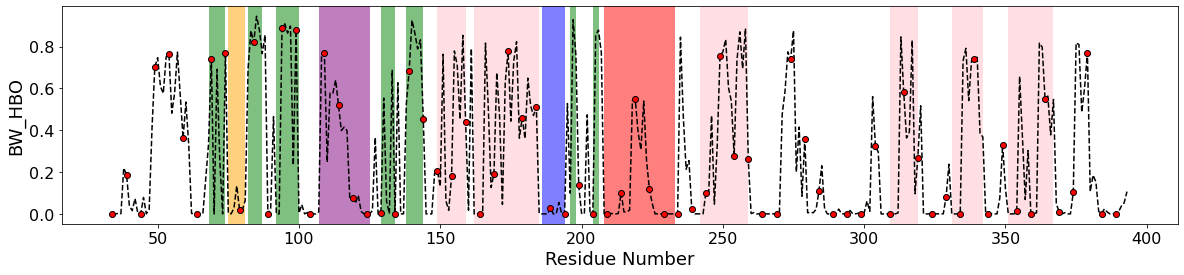

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.plot(res_num, boltz_weighted_sum, '--o',color='k', markerfacecolor='red',markevery=5)
plt.xlabel('Residue Number',fontsize=18)
plt.ylabel('BW_HBO',fontsize=18)

plt.axvspan(res_lst_start[0], res_lst_end[0], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[1], res_lst_end[1], facecolor='orange', alpha=0.5)
plt.axvspan(res_lst_start[2], res_lst_end[2], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[3], res_lst_end[3], facecolor='green', alpha=0.5)

plt.axvspan(res_lst_start[4], res_lst_end[4], facecolor='purple', alpha=0.5)
plt.axvspan(res_lst_start[5], res_lst_end[5], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[6], res_lst_end[6], facecolor='green', alpha=0.5)


plt.axvspan(res_lst_start[7], res_lst_end[7], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[8], res_lst_end[8], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[9], res_lst_end[9], facecolor='blue', alpha=0.5)
plt.axvspan(res_lst_start[10], res_lst_end[10], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[11], res_lst_end[11], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[12], res_lst_end[12], facecolor='red', alpha=0.5)
plt.axvspan(res_lst_start[13], res_lst_end[13], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[14], res_lst_end[14], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[15], res_lst_end[15], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[16], res_lst_end[16], facecolor='pink', alpha=0.5)



plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_hbond.png',bbox_inches='tight', dpi=300)

In [ ]:
np.min(boltz_weighted_sum)

In [ ]:
np.savetxt('BWHBO_WT.txt' ,boltz_weighted_sum)

In [4]:
boltz_weighted_sum = np.loadtxt('BWHBO_WT.txt')

### Boltzman weighted SASA per residue

In [ ]:
import numpy as np
sasa_0 = np.zeros((1,5652))

In [ ]:
for i in range(20,40):
    temp =np.loadtxt('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/MEK_SASA/traj_'+str(i)+'/sasa_'+str(i)+'.txt') 
    sasa_0 = np.vstack((sasa_0,temp))
    print(i)

In [ ]:
sasa_0_temp = sasa_0[1:]

In [ ]:
sasa_0_temp.shape

In [ ]:
len(sasa_0_temp[1])

In [ ]:
sasa_0_temp[0]

In [ ]:
sasa_0_N = sasa_0_temp[:,p[0].tolist()]


In [ ]:
sasa_0_N.shape

In [ ]:
sasa_0_H = np.zeros_like((sasa_0_N ))

In [ ]:
sasa_0_H.shape

In [ ]:
sasa_0_N = np.transpose(sasa_0_N)
sasa_0_H = np.transpose(sasa_0_H)

In [ ]:
sasa_0_H.shape

In [ ]:
sasa_0_N.shape

In [ ]:
sasa_0_H

In [ ]:
p_h

In [ ]:
p[0]

In [ ]:
for i in range(0,len(p[0])):
    
    if  p[0][i]+1 in p_h:
        sasa_0_H[i] = sasa_0_temp[:,p[0][i]+1]
   

In [ ]:
sasa_0_H.shape    

In [ ]:
sasa_0_H

In [ ]:
sasa_0_N

In [ ]:
sasa_res = sasa_0_H + sasa_0_N

In [ ]:
sasa_res

In [ ]:
np.savetxt('sasa_res_part2.txt',sasa_res)

In [9]:
s1 = np.loadtxt('sasa_res_part1.txt')
s2 = np.loadtxt('sasa_res_part2.txt')

In [10]:
s1.shape

(360, 130020)

In [11]:
s2.shape

(360, 130020)

In [12]:
s3 = np.hstack((s1,s2))

In [13]:
s3.shape

(360, 260040)

In [14]:
partition_func = np.loadtxt('partition_func.txt')

In [15]:
boltz_weighted_sasa = s3 * partition_func


In [16]:
boltz_weighted_sasa_square = (s3**2) * partition_func

In [17]:
boltz_weighted_sasa_square.shape

(360, 260040)

In [4]:
boltz_weighted_sasa_sum_square = np.sum(boltz_weighted_sasa_square,axis=1)
#boltz_weighted_sasa_sum_square

In [19]:
boltz_weighted_sasa.shape

(360, 260040)

In [3]:
boltz_weighted_sasa_sum = np.sum(boltz_weighted_sasa,axis=1)
#boltz_weighted_sasa_sum

In [2]:
res_num = np.arange(34,394,1)
#res_num

In [22]:
boltz_weighted_sasa_sum.shape

(360,)

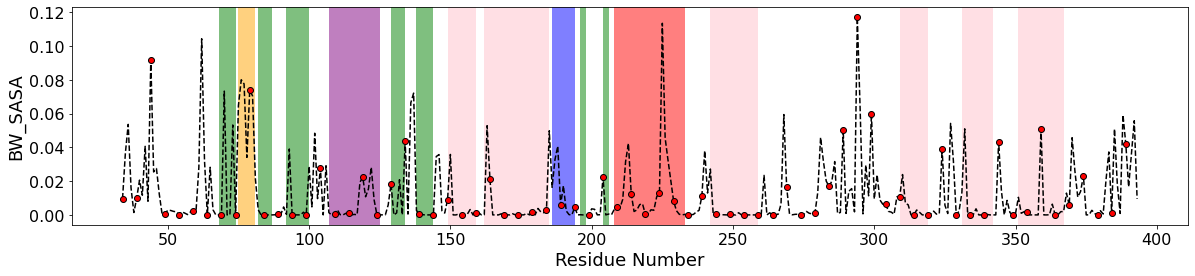

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.plot(res_num, boltz_weighted_sasa_sum, '--o',color='black', markerfacecolor='red',markevery=5)
plt.xlabel('Residue Number',fontsize=18)
plt.ylabel('BW_SASA',fontsize=18)



plt.axvspan(res_lst_start[0], res_lst_end[0], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[1], res_lst_end[1], facecolor='orange', alpha=0.5)
plt.axvspan(res_lst_start[2], res_lst_end[2], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[3], res_lst_end[3], facecolor='green', alpha=0.5)

plt.axvspan(res_lst_start[4], res_lst_end[4], facecolor='purple', alpha=0.5)
plt.axvspan(res_lst_start[5], res_lst_end[5], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[6], res_lst_end[6], facecolor='green', alpha=0.5)


plt.axvspan(res_lst_start[7], res_lst_end[7], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[8], res_lst_end[8], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[9], res_lst_end[9], facecolor='blue', alpha=0.5)
plt.axvspan(res_lst_start[10], res_lst_end[10], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[11], res_lst_end[11], facecolor='green', alpha=0.5)
plt.axvspan(res_lst_start[12], res_lst_end[12], facecolor='red', alpha=0.5)
plt.axvspan(res_lst_start[13], res_lst_end[13], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[14], res_lst_end[14], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[15], res_lst_end[15], facecolor='pink', alpha=0.5)
plt.axvspan(res_lst_start[16], res_lst_end[16], facecolor='pink', alpha=0.5)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_sasa.png',bbox_inches='tight', dpi=300)

In [ ]:
np.savetxt('BWSASA_WT.txt' ,boltz_weighted_sasa_sum)

In [23]:
boltz_weighted_sasa_sum = np.loadtxt('BWSASA_WT.txt')

In [24]:
sur = np.loadtxt('BWSASA_WT.txt')

In [25]:
hbo = np.loadtxt('BWHBO_WT.txt')

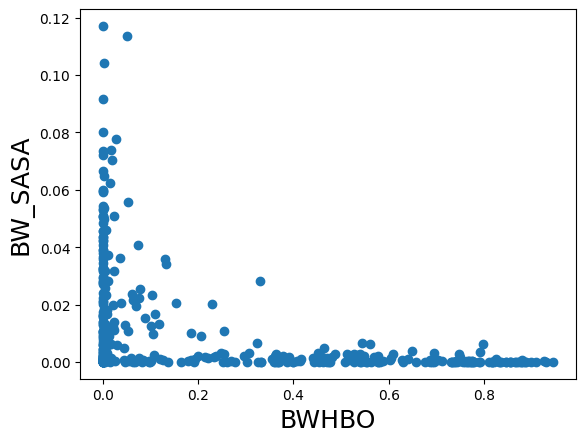

In [26]:
import matplotlib.pyplot as plt
plt.scatter(hbo,sur)
plt.xlabel('BWHBO',fontsize=18)
plt.ylabel('BW_SASA',fontsize=18)
plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_sasa_hbond.png',bbox_inches='tight', dpi=300)

In [27]:
var_sasa =   boltz_weighted_sasa_sum_square    - (boltz_weighted_sasa_sum)**2

In [28]:
var_sasa.shape

(360,)

In [29]:
std_sasa = np.sqrt(boltz_weighted_sasa_sum_square      - (boltz_weighted_sasa_sum)**2)

In [30]:
std_sasa.shape

(360,)

In [31]:
np.min(std_sasa)

0.0

In [32]:
norm_sasa = []
for i in range(0,len(std_sasa)):
    if boltz_weighted_sasa_sum[i] ==0:
        norm_sasa.append(0.0001)
    else:
        norm_sasa.append(std_sasa[i]/boltz_weighted_sasa_sum[i] )
        
    
    
    

In [33]:
np.max(np.array(norm_sasa))


24218238.502136145

In [ ]:
sum(i >=10 for i in norm_sasa)

In [ ]:
sum(e for e in norm_sasa if e>=10)  /  89

Text(0, 0.5, 'Norm_std_dev_SASA')

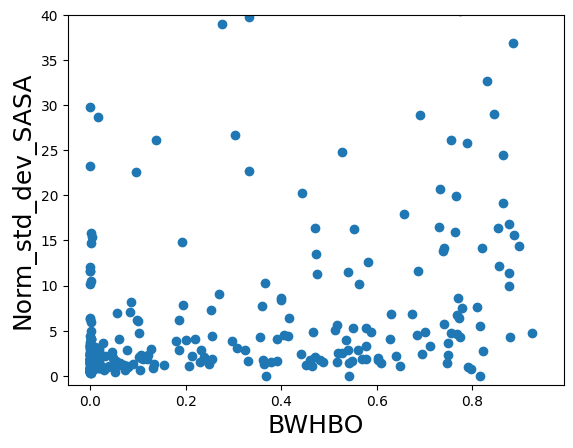

In [34]:
import matplotlib.pyplot as plt
plt.scatter(hbo,norm_sasa)
plt.ylim((-1,40))
plt.xlabel('BWHBO',fontsize=18)
plt.ylabel('Norm_std_dev_SASA',fontsize=18)
#plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)
#plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)

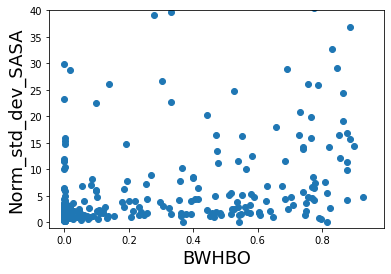

In [57]:
import matplotlib.pyplot as plt
plt.scatter(hbo,norm_sasa)
plt.ylim((-1,40))
plt.xlabel('BWHBO',fontsize=18)
plt.ylabel('Norm_std_dev_SASA',fontsize=18)
plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)
plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)

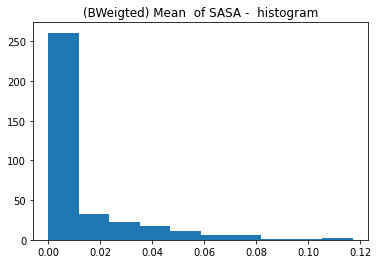

In [58]:
plt.hist(boltz_weighted_sasa_sum)
plt.title('(BWeigted) Mean  of SASA -  histogram')
#plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_var_sasa_histo.png',bbox_inches='tight', dpi=300)
plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_histo_mean_sasa.png',bbox_inches='tight', dpi=300)

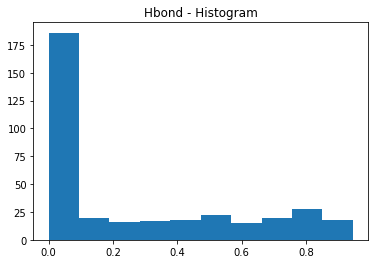

In [59]:
plt.hist(hbo)
plt.title('Hbond - Histogram')
plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_histo_hbond.png',bbox_inches='tight', dpi=300)

plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_histo_hbond.png',bbox_inches='tight', dpi=300)



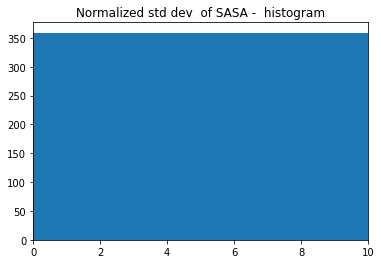

In [60]:
plt.hist(norm_sasa)
plt.xlim((0,10))
plt.title('Normalized std dev  of SASA -  histogram')
plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_var_sasa_histo.png',bbox_inches='tight', dpi=300)
plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_histo_std_dev_sasa.png',bbox_inches='tight', dpi=300)

In [35]:
p1 = list(range(43-34,52-34))
p2  = list(range(53-34,67-34))
p3  = list(range(69-34,83-34))
p4 = list(range(350-34,360-34))
p5 = list(range(357-34,367-34))
p6 = list(range(377-34,393-34))

hbo_pep_1 = []
norm_sasa_pep_1 = []

hbo_pep_2 = []
norm_sasa_pep_2 = []


hbo_pep_3 = []
norm_sasa_pep_3 = []


hbo_pep_4 = []
norm_sasa_pep_4 = []


hbo_pep_5 = []
norm_sasa_pep_5 = []


hbo_pep_6 = []
norm_sasa_pep_6 = []

for i in range(0,len(hbo)):
    if i in p1:
        hbo_pep_1.append(hbo[i])
        norm_sasa_pep_1.append(norm_sasa[i])
    
    if i in p2:
        hbo_pep_2.append(hbo[i])
        norm_sasa_pep_2.append(norm_sasa[i])
        
    if i in p3:
        hbo_pep_3.append(hbo[i])
        norm_sasa_pep_3.append(norm_sasa[i])
        
    if i in p4:
        hbo_pep_4.append(hbo[i])
        norm_sasa_pep_4.append(norm_sasa[i])
        
    if i in p5:
        hbo_pep_5.append(hbo[i])
        norm_sasa_pep_5.append(norm_sasa[i])
        
    if i in p6:
        hbo_pep_6.append(hbo[i])
        norm_sasa_pep_6.append(norm_sasa[i])
        
    
    

Text(0, 0.5, 'Log(Norm_std_dev_SASA)')

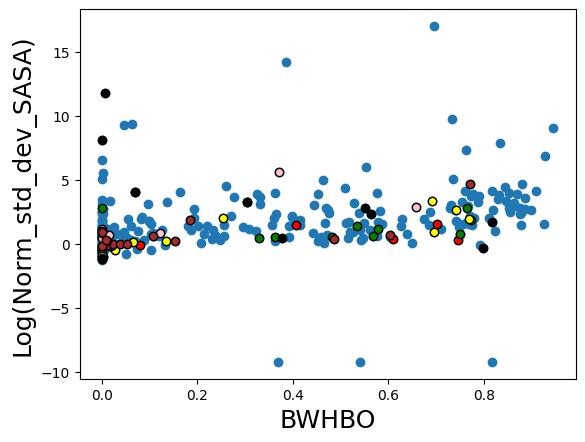

In [36]:
import matplotlib.pyplot as plt
plt.scatter(hbo,np.log(norm_sasa))
plt.scatter(hbo_pep_1,np.log(norm_sasa_pep_1),color='r',edgecolor='k')
plt.scatter(hbo_pep_2,np.log(norm_sasa_pep_2),color='g',edgecolor='k')
plt.scatter(hbo_pep_3,np.log(norm_sasa_pep_3),color='yellow',edgecolor='k')
plt.scatter(hbo_pep_4,np.log(norm_sasa_pep_4),color='pink',edgecolor='k')
plt.scatter(hbo_pep_5,np.log(norm_sasa_pep_5),color='k',edgecolor='k')
plt.scatter(hbo_pep_6,np.log(norm_sasa_pep_6),color='brown',edgecolor='k')
#plt.ylim((-1,40))
plt.xlabel('BWHBO',fontsize=18)
plt.ylabel('Log(Norm_std_dev_SASA)',fontsize=18)
#plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)
#plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_log_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)

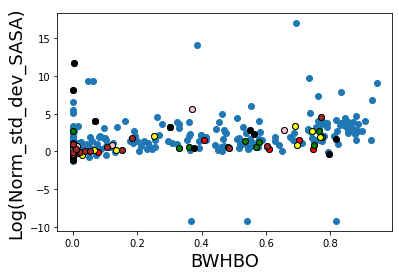

In [62]:
import matplotlib.pyplot as plt
plt.scatter(hbo,np.log(norm_sasa))
plt.scatter(hbo_pep_1,np.log(norm_sasa_pep_1),color='r',edgecolor='k')
plt.scatter(hbo_pep_2,np.log(norm_sasa_pep_2),color='g',edgecolor='k')
plt.scatter(hbo_pep_3,np.log(norm_sasa_pep_3),color='yellow',edgecolor='k')
plt.scatter(hbo_pep_4,np.log(norm_sasa_pep_4),color='pink',edgecolor='k')
plt.scatter(hbo_pep_5,np.log(norm_sasa_pep_5),color='k',edgecolor='k')
plt.scatter(hbo_pep_6,np.log(norm_sasa_pep_6),color='brown',edgecolor='k')
#plt.ylim((-1,40))
plt.xlabel('BWHBO',fontsize=18)
plt.ylabel('Log(Norm_std_dev_SASA)',fontsize=18)
plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)
plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_log_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)

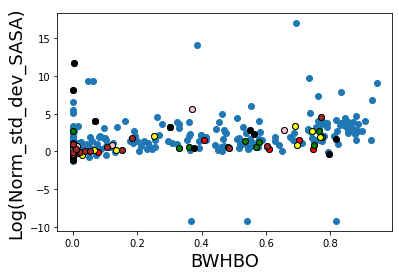

In [63]:
import matplotlib.pyplot as plt
plt.scatter(hbo,np.log(norm_sasa))
plt.scatter(hbo_pep_1,np.log(norm_sasa_pep_1),color='r',edgecolor='k')
plt.scatter(hbo_pep_2,np.log(norm_sasa_pep_2),color='g',edgecolor='k')
plt.scatter(hbo_pep_3,np.log(norm_sasa_pep_3),color='yellow',edgecolor='k')
plt.scatter(hbo_pep_4,np.log(norm_sasa_pep_4),color='pink',edgecolor='k')
plt.scatter(hbo_pep_5,np.log(norm_sasa_pep_5),color='k',edgecolor='k')
plt.scatter(hbo_pep_6,np.log(norm_sasa_pep_6),color='brown',edgecolor='k')
#plt.ylim((-1,40))
plt.xlabel('BWHBO',fontsize=18)
plt.ylabel('Log(Norm_std_dev_SASA)',fontsize=18)
plt.savefig('/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_wt_boltz_weighted_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)
plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_log_std_dev_sasa_hbond.png',bbox_inches='tight', dpi=300)

In [64]:
np.max(np.array(norm_sasa))

24218238.502136145

/var/folders/8z/6ldhp0852lx2cvvl61m7tdv00000gp/T/ipykernel_99254/632188971.py:168: UserWarning: Legend does not support 'EX1' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(('EX1', 'EX2'), 'center')
/var/folders/8z/6ldhp0852lx2cvvl61m7tdv00000gp/T/ipykernel_99254/632188971.py:168: UserWarning: Legend does not support 'EX2' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(('EX1', 'EX2'), 'center')


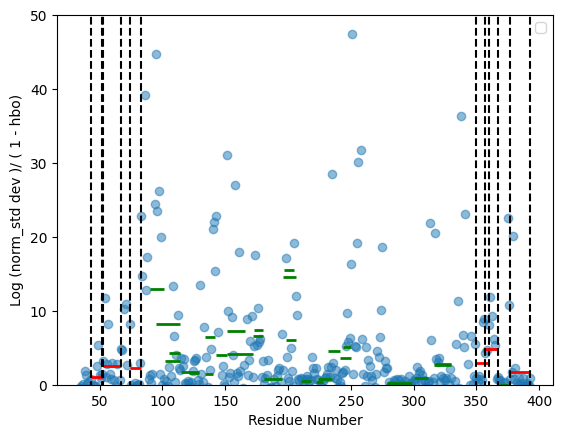

In [37]:
import matplotlib.pyplot as plt
res_num = np.arange(34,394,1)
k = 1
thbo = k *  (1 - hbo)
ty =  (np.log(norm_sasa)/ thbo)


ty1 = ty[43-34:52-34]
ty2 = ty[53-34:67-34]
ty3 =  ty[69-34:83-34]
ty4 = ty[350-34:360-34]
ty5 = ty[357-34:367-34]
ty6 =ty[377-34:393-34]



ty7 = ty[90-34:101-34]
ty8 = ty[95-34:114-34]
ty9 =  ty[102-34:114-34]
ty10 = ty[105-34:114-34]
ty11 = ty[143-34:151-34]
ty12 =ty[151-34:166-34]


ty13 = ty[151-34:172-34]
ty14 = ty[115-34:129-34]
ty15 =  ty[121-34:129-34]
ty16 = ty[134-34:140-34]
ty17 = ty[134-34:142-34]
ty18 =ty[172-34:180-34]


ty19 = ty[173-34:180-34]
ty20 = ty[181-34:195-34]
ty21 =  ty[196-34:206-34]
ty22 = ty[197-34:205-34]
ty23 = ty[198-34:206-34]
ty24 =ty[210-34:218-34]


ty25 = ty[222-34:228-34]
ty26 = ty[224-34:235-34]
ty27 =  ty[232-34:241-34]
ty28 = ty[241-34:250-34]
ty29 = ty[244-34:250-34]
ty30 =ty[279-34:299-34]


ty31 = ty[300-34:311-34]
ty32 = ty[316-34:330-34]
ty33 =  ty[317-34:330-34]
ty34 = ty[369-34:375-34]

ty1_m = np.mean(ty1)
ty2_m = np.mean(ty2)
ty3_m =  np.mean(ty3)
ty4_m = np.mean(ty4)
ty5_m = np.mean(ty5)
ty6_m = np.mean(ty6)


ty7_m = np.mean(ty7)
ty8_m = np.mean(ty8)
ty9_m =  np.mean(ty9)
ty10_m = np.mean(ty10)
ty11_m = np.mean(ty11)
ty12_m = np.mean(ty12)


ty13_m = np.mean(ty13)
ty14_m = np.mean(ty14)
ty15_m =  np.mean(ty15)
ty16_m = np.mean(ty16)
ty17_m = np.mean(ty17)
ty18_m = np.mean(ty18)


ty19_m = np.mean(ty19)
ty20_m = np.mean(ty20)
ty21_m =  np.mean(ty21)
ty22_m = np.mean(ty22)
ty23_m = np.mean(ty23)
ty24_m = np.mean(ty24)


ty25_m = np.mean(ty25)
ty26_m = np.mean(ty26)
ty27_m =  np.mean(ty27)
ty28_m = np.mean(ty28)
ty29_m = np.mean(ty29)
ty30_m = np.mean(ty30)

ty31_m = np.mean(ty31)
ty32_m = np.mean(ty32)
ty33_m =  np.mean(ty33)
ty34_m = np.mean(ty34)










fig, ax = plt.subplots()
ax.scatter(res_num, (np.log(norm_sasa)/thbo), alpha=.5)
ax.set_ylim((-2,10))
ax.hlines(y=ty1_m , xmin=43, xmax=52, linewidth=2, color='r')
ax.vlines(x=43, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=52, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty2_m , xmin=53, xmax=67, linewidth=2, color='r')
ax.vlines(x=53, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=67, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty3_m , xmin=74, xmax=83, linewidth=2, color='r')
ax.vlines(x=74, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=83, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty4_m , xmin=350, xmax=360, linewidth=2, color='r')
ax.vlines(x=350, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=360, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty5_m , xmin=357, xmax=367, linewidth=2, color='r')
ax.vlines(x=357, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=367, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty6_m , xmin=377, xmax=393, linewidth=2, color='r')
ax.vlines(x=377, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=393, ymin=-2, ymax=50, color='k', linestyle='--')


ax.hlines(y=ty7_m , xmin=90, xmax=101, linewidth=2, color='g')
ax.hlines(y=ty8_m , xmin=95, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty9_m , xmin=102, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty10_m , xmin=105, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty11_m , xmin=143, xmax=151, linewidth=2, color='g')
ax.hlines(y=ty12_m , xmin=151, xmax=166, linewidth=2, color='g')
ax.hlines(y=ty13_m , xmin=151, xmax=172, linewidth=2, color='g')
ax.hlines(y=ty14_m , xmin=115, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty15_m , xmin=121, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty16_m , xmin=134, xmax=140, linewidth=2, color='g')
ax.hlines(y=ty17_m , xmin=134, xmax=142, linewidth=2, color='g')
ax.hlines(y=ty18_m , xmin=172, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty19_m , xmin=173, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty20_m , xmin=181, xmax=195, linewidth=2, color='g')
ax.hlines(y=ty21_m , xmin=196, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty22_m , xmin=197, xmax=205, linewidth=2, color='g')
ax.hlines(y=ty23_m , xmin=198, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty24_m , xmin=210, xmax=218, linewidth=2, color='g')
ax.hlines(y=ty25_m , xmin=222, xmax=228, linewidth=2, color='g')
ax.hlines(y=ty26_m , xmin=224, xmax=235, linewidth=2, color='g')
ax.hlines(y=ty27_m , xmin=232, xmax=241, linewidth=2, color='g')
ax.hlines(y=ty28_m , xmin=241, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty29_m , xmin=244, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty30_m , xmin=279, xmax=299, linewidth=2, color='g')
ax.hlines(y=ty31_m , xmin=300, xmax=311, linewidth=2, color='g')
ax.hlines(y=ty32_m , xmin=316, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty33_m , xmin=317, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty34_m , xmin=369, xmax=375, linewidth=2, color='g')


plt.ylim((0,50))
plt.ylabel('Log (norm_std dev )/ ( 1 - hbo)')
plt.xlabel('Residue Number')
plt.legend(('EX1', 'EX2'), 'center')
#plt.savefig('/Users/owner/Desktop/VProcess/sasa_kp.png',bbox_inches='tight', dpi=300)

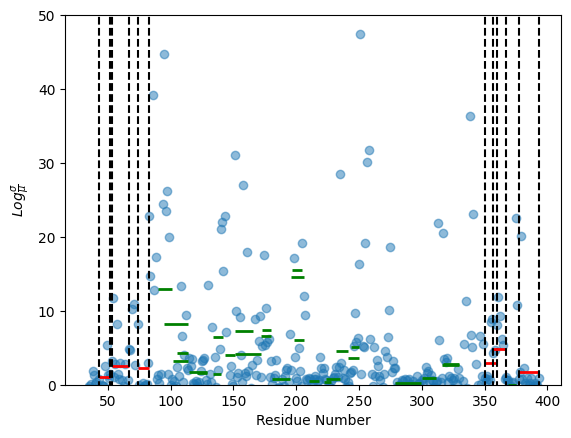

In [41]:
import matplotlib.pyplot as plt
res_num = np.arange(34,394,1)
k = 1
thbo = k *  (1 - hbo)
ty =  (np.log(norm_sasa)/ thbo)


ty1 = ty[43-34:52-34]
ty2 = ty[53-34:67-34]
ty3 =  ty[69-34:83-34]
ty4 = ty[350-34:360-34]
ty5 = ty[357-34:367-34]
ty6 =ty[377-34:393-34]



ty7 = ty[90-34:101-34]
ty8 = ty[95-34:114-34]
ty9 =  ty[102-34:114-34]
ty10 = ty[105-34:114-34]
ty11 = ty[143-34:151-34]
ty12 =ty[151-34:166-34]


ty13 = ty[151-34:172-34]
ty14 = ty[115-34:129-34]
ty15 =  ty[121-34:129-34]
ty16 = ty[134-34:140-34]
ty17 = ty[134-34:142-34]
ty18 =ty[172-34:180-34]


ty19 = ty[173-34:180-34]
ty20 = ty[181-34:195-34]
ty21 =  ty[196-34:206-34]
ty22 = ty[197-34:205-34]
ty23 = ty[198-34:206-34]
ty24 =ty[210-34:218-34]


ty25 = ty[222-34:228-34]
ty26 = ty[224-34:235-34]
ty27 =  ty[232-34:241-34]
ty28 = ty[241-34:250-34]
ty29 = ty[244-34:250-34]
ty30 =ty[279-34:299-34]


ty31 = ty[300-34:311-34]
ty32 = ty[316-34:330-34]
ty33 =  ty[317-34:330-34]
ty34 = ty[369-34:375-34]

ty1_m = np.mean(ty1)
ty2_m = np.mean(ty2)
ty3_m =  np.mean(ty3)
ty4_m = np.mean(ty4)
ty5_m = np.mean(ty5)
ty6_m = np.mean(ty6)


ty7_m = np.mean(ty7)
ty8_m = np.mean(ty8)
ty9_m =  np.mean(ty9)
ty10_m = np.mean(ty10)
ty11_m = np.mean(ty11)
ty12_m = np.mean(ty12)


ty13_m = np.mean(ty13)
ty14_m = np.mean(ty14)
ty15_m =  np.mean(ty15)
ty16_m = np.mean(ty16)
ty17_m = np.mean(ty17)
ty18_m = np.mean(ty18)


ty19_m = np.mean(ty19)
ty20_m = np.mean(ty20)
ty21_m =  np.mean(ty21)
ty22_m = np.mean(ty22)
ty23_m = np.mean(ty23)
ty24_m = np.mean(ty24)


ty25_m = np.mean(ty25)
ty26_m = np.mean(ty26)
ty27_m =  np.mean(ty27)
ty28_m = np.mean(ty28)
ty29_m = np.mean(ty29)
ty30_m = np.mean(ty30)

ty31_m = np.mean(ty31)
ty32_m = np.mean(ty32)
ty33_m =  np.mean(ty33)
ty34_m = np.mean(ty34)










fig, ax = plt.subplots()
ax.scatter(res_num, (np.log(norm_sasa)/thbo), alpha=.5)
ax.set_ylim((-2,10))
ax.hlines(y=ty1_m , xmin=43, xmax=52, linewidth=2, color='r')
ax.vlines(x=43, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=52, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty2_m , xmin=53, xmax=67, linewidth=2, color='r')
ax.vlines(x=53, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=67, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty3_m , xmin=74, xmax=83, linewidth=2, color='r')
ax.vlines(x=74, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=83, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty4_m , xmin=350, xmax=360, linewidth=2, color='r')
ax.vlines(x=350, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=360, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty5_m , xmin=357, xmax=367, linewidth=2, color='r')
ax.vlines(x=357, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=367, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty6_m , xmin=377, xmax=393, linewidth=2, color='r')
ax.vlines(x=377, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=393, ymin=-2, ymax=50, color='k', linestyle='--')


ax.hlines(y=ty7_m , xmin=90, xmax=101, linewidth=2, color='g')
ax.hlines(y=ty8_m , xmin=95, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty9_m , xmin=102, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty10_m , xmin=105, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty11_m , xmin=143, xmax=151, linewidth=2, color='g')
ax.hlines(y=ty12_m , xmin=151, xmax=166, linewidth=2, color='g')
ax.hlines(y=ty13_m , xmin=151, xmax=172, linewidth=2, color='g')
ax.hlines(y=ty14_m , xmin=115, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty15_m , xmin=121, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty16_m , xmin=134, xmax=140, linewidth=2, color='g')
ax.hlines(y=ty17_m , xmin=134, xmax=142, linewidth=2, color='g')
ax.hlines(y=ty18_m , xmin=172, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty19_m , xmin=173, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty20_m , xmin=181, xmax=195, linewidth=2, color='g')
ax.hlines(y=ty21_m , xmin=196, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty22_m , xmin=197, xmax=205, linewidth=2, color='g')
ax.hlines(y=ty23_m , xmin=198, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty24_m , xmin=210, xmax=218, linewidth=2, color='g')
ax.hlines(y=ty25_m , xmin=222, xmax=228, linewidth=2, color='g')
ax.hlines(y=ty26_m , xmin=224, xmax=235, linewidth=2, color='g')
ax.hlines(y=ty27_m , xmin=232, xmax=241, linewidth=2, color='g')
ax.hlines(y=ty28_m , xmin=241, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty29_m , xmin=244, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty30_m , xmin=279, xmax=299, linewidth=2, color='g')
ax.hlines(y=ty31_m , xmin=300, xmax=311, linewidth=2, color='g')
ax.hlines(y=ty32_m , xmin=316, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty33_m , xmin=317, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty34_m , xmin=369, xmax=375, linewidth=2, color='g')


plt.ylim((0,50))

plt.ylabel(r'$Log \frac{\sigma}{\mu}$')
#plt.ylabel('Log (norm_std dev )/ ( 1 - hbo)')
plt.xlabel('Residue Number')
#plt.legend(('EX1', 'EX2'), 'center')
plt.savefig('/Users/owner/Desktop/VProcess/sasa_kp_100.png',bbox_inches='tight', dpi=300)

<ipython-input-71-a57757073ab7>:169: UserWarning: Legend does not support 'EX1' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(('EX1', 'EX2'), 'center')
<ipython-input-71-a57757073ab7>:169: UserWarning: Legend does not support 'EX2' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(('EX1', 'EX2'), 'center')


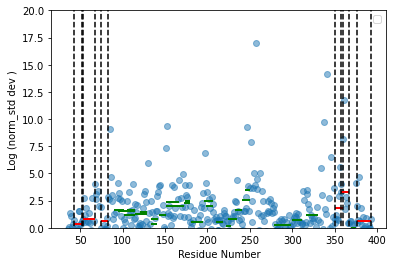

In [71]:
#Long norm sasa
import matplotlib.pyplot as plt
res_num = np.arange(34,394,1)
k = 1
thbo = k *  (1 - hbo)
ty =  np.log(norm_sasa)


ty1 = ty[43-34:52-34]
ty2 = ty[53-34:67-34]
ty3 =  ty[69-34:83-34]
ty4 = ty[350-34:360-34]
ty5 = ty[357-34:367-34]
ty6 =ty[377-34:393-34]



ty7 = ty[90-34:101-34]
ty8 = ty[95-34:114-34]
ty9 =  ty[102-34:114-34]
ty10 = ty[105-34:114-34]
ty11 = ty[143-34:151-34]
ty12 =ty[151-34:166-34]


ty13 = ty[151-34:172-34]
ty14 = ty[115-34:129-34]
ty15 =  ty[121-34:129-34]
ty16 = ty[134-34:140-34]
ty17 = ty[134-34:142-34]
ty18 =ty[172-34:180-34]


ty19 = ty[173-34:180-34]
ty20 = ty[181-34:195-34]
ty21 =  ty[196-34:206-34]
ty22 = ty[197-34:205-34]
ty23 = ty[198-34:206-34]
ty24 =ty[210-34:218-34]


ty25 = ty[222-34:228-34]
ty26 = ty[224-34:235-34]
ty27 =  ty[232-34:241-34]
ty28 = ty[241-34:250-34]
ty29 = ty[244-34:250-34]
ty30 =ty[279-34:299-34]


ty31 = ty[300-34:311-34]
ty32 = ty[316-34:330-34]
ty33 =  ty[317-34:330-34]
ty34 = ty[369-34:375-34]

ty1_m = np.mean(ty1)
ty2_m = np.mean(ty2)
ty3_m =  np.mean(ty3)
ty4_m = np.mean(ty4)
ty5_m = np.mean(ty5)
ty6_m = np.mean(ty6)


ty7_m = np.mean(ty7)
ty8_m = np.mean(ty8)
ty9_m =  np.mean(ty9)
ty10_m = np.mean(ty10)
ty11_m = np.mean(ty11)
ty12_m = np.mean(ty12)


ty13_m = np.mean(ty13)
ty14_m = np.mean(ty14)
ty15_m =  np.mean(ty15)
ty16_m = np.mean(ty16)
ty17_m = np.mean(ty17)
ty18_m = np.mean(ty18)


ty19_m = np.mean(ty19)
ty20_m = np.mean(ty20)
ty21_m =  np.mean(ty21)
ty22_m = np.mean(ty22)
ty23_m = np.mean(ty23)
ty24_m = np.mean(ty24)


ty25_m = np.mean(ty25)
ty26_m = np.mean(ty26)
ty27_m =  np.mean(ty27)
ty28_m = np.mean(ty28)
ty29_m = np.mean(ty29)
ty30_m = np.mean(ty30)

ty31_m = np.mean(ty31)
ty32_m = np.mean(ty32)
ty33_m =  np.mean(ty33)
ty34_m = np.mean(ty34)










fig, ax = plt.subplots()
ax.scatter(res_num, ty, alpha=.5)
ax.set_ylim((-2,10))
ax.hlines(y=ty1_m , xmin=43, xmax=52, linewidth=2, color='r')
ax.vlines(x=43, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=52, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty2_m , xmin=53, xmax=67, linewidth=2, color='r')
ax.vlines(x=53, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=67, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty3_m , xmin=74, xmax=83, linewidth=2, color='r')
ax.vlines(x=74, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=83, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty4_m , xmin=350, xmax=360, linewidth=2, color='r')
ax.vlines(x=350, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=360, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty5_m , xmin=357, xmax=367, linewidth=2, color='r')
ax.vlines(x=357, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=367, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty6_m , xmin=377, xmax=393, linewidth=2, color='r')
ax.vlines(x=377, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=393, ymin=-2, ymax=50, color='k', linestyle='--')


ax.hlines(y=ty7_m , xmin=90, xmax=101, linewidth=2, color='g')
ax.hlines(y=ty8_m , xmin=95, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty9_m , xmin=102, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty10_m , xmin=105, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty11_m , xmin=143, xmax=151, linewidth=2, color='g')
ax.hlines(y=ty12_m , xmin=151, xmax=166, linewidth=2, color='g')
ax.hlines(y=ty13_m , xmin=151, xmax=172, linewidth=2, color='g')
ax.hlines(y=ty14_m , xmin=115, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty15_m , xmin=121, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty16_m , xmin=134, xmax=140, linewidth=2, color='g')
ax.hlines(y=ty17_m , xmin=134, xmax=142, linewidth=2, color='g')
ax.hlines(y=ty18_m , xmin=172, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty19_m , xmin=173, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty20_m , xmin=181, xmax=195, linewidth=2, color='g')
ax.hlines(y=ty21_m , xmin=196, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty22_m , xmin=197, xmax=205, linewidth=2, color='g')
ax.hlines(y=ty23_m , xmin=198, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty24_m , xmin=210, xmax=218, linewidth=2, color='g')
ax.hlines(y=ty25_m , xmin=222, xmax=228, linewidth=2, color='g')
ax.hlines(y=ty26_m , xmin=224, xmax=235, linewidth=2, color='g')
ax.hlines(y=ty27_m , xmin=232, xmax=241, linewidth=2, color='g')
ax.hlines(y=ty28_m , xmin=241, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty29_m , xmin=244, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty30_m , xmin=279, xmax=299, linewidth=2, color='g')
ax.hlines(y=ty31_m , xmin=300, xmax=311, linewidth=2, color='g')
ax.hlines(y=ty32_m , xmin=316, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty33_m , xmin=317, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty34_m , xmin=369, xmax=375, linewidth=2, color='g')


plt.ylim((0,20))
plt.ylabel('Log (norm_std dev )')
plt.xlabel('Residue Number')
plt.legend(('EX1', 'EX2'), 'center')
plt.savefig('/Users/owner/Desktop/VProcess/sasa_log_norm_sasa_res_num.png',bbox_inches='tight', dpi=300)

<ipython-input-73-685d736e9c64>:169: UserWarning: Legend does not support 'EX1' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(('EX1', 'EX2'), 'center')
<ipython-input-73-685d736e9c64>:169: UserWarning: Legend does not support 'EX2' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(('EX1', 'EX2'), 'center')


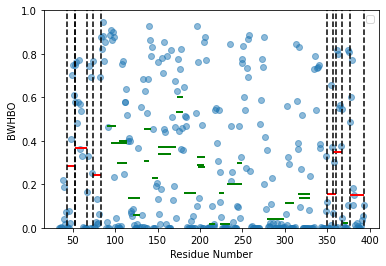

In [73]:
#BWHBO
import matplotlib.pyplot as plt
res_num = np.arange(34,394,1)
k = 1
thbo = k *  (1 - hbo)
ty =  (1- thbo)


ty1 = ty[43-34:52-34]
ty2 = ty[53-34:67-34]
ty3 =  ty[69-34:83-34]
ty4 = ty[350-34:360-34]
ty5 = ty[357-34:367-34]
ty6 =ty[377-34:393-34]



ty7 = ty[90-34:101-34]
ty8 = ty[95-34:114-34]
ty9 =  ty[102-34:114-34]
ty10 = ty[105-34:114-34]
ty11 = ty[143-34:151-34]
ty12 =ty[151-34:166-34]


ty13 = ty[151-34:172-34]
ty14 = ty[115-34:129-34]
ty15 =  ty[121-34:129-34]
ty16 = ty[134-34:140-34]
ty17 = ty[134-34:142-34]
ty18 =ty[172-34:180-34]


ty19 = ty[173-34:180-34]
ty20 = ty[181-34:195-34]
ty21 =  ty[196-34:206-34]
ty22 = ty[197-34:205-34]
ty23 = ty[198-34:206-34]
ty24 =ty[210-34:218-34]


ty25 = ty[222-34:228-34]
ty26 = ty[224-34:235-34]
ty27 =  ty[232-34:241-34]
ty28 = ty[241-34:250-34]
ty29 = ty[244-34:250-34]
ty30 =ty[279-34:299-34]


ty31 = ty[300-34:311-34]
ty32 = ty[316-34:330-34]
ty33 =  ty[317-34:330-34]
ty34 = ty[369-34:375-34]

ty1_m = np.mean(ty1)
ty2_m = np.mean(ty2)
ty3_m =  np.mean(ty3)
ty4_m = np.mean(ty4)
ty5_m = np.mean(ty5)
ty6_m = np.mean(ty6)


ty7_m = np.mean(ty7)
ty8_m = np.mean(ty8)
ty9_m =  np.mean(ty9)
ty10_m = np.mean(ty10)
ty11_m = np.mean(ty11)
ty12_m = np.mean(ty12)


ty13_m = np.mean(ty13)
ty14_m = np.mean(ty14)
ty15_m =  np.mean(ty15)
ty16_m = np.mean(ty16)
ty17_m = np.mean(ty17)
ty18_m = np.mean(ty18)


ty19_m = np.mean(ty19)
ty20_m = np.mean(ty20)
ty21_m =  np.mean(ty21)
ty22_m = np.mean(ty22)
ty23_m = np.mean(ty23)
ty24_m = np.mean(ty24)


ty25_m = np.mean(ty25)
ty26_m = np.mean(ty26)
ty27_m =  np.mean(ty27)
ty28_m = np.mean(ty28)
ty29_m = np.mean(ty29)
ty30_m = np.mean(ty30)

ty31_m = np.mean(ty31)
ty32_m = np.mean(ty32)
ty33_m =  np.mean(ty33)
ty34_m = np.mean(ty34)










fig, ax = plt.subplots()
ax.scatter(res_num, ty, alpha=.5)
ax.set_ylim((-2,10))
ax.hlines(y=ty1_m , xmin=43, xmax=52, linewidth=2, color='r')
ax.vlines(x=43, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=52, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty2_m , xmin=53, xmax=67, linewidth=2, color='r')
ax.vlines(x=53, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=67, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty3_m , xmin=74, xmax=83, linewidth=2, color='r')
ax.vlines(x=74, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=83, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty4_m , xmin=350, xmax=360, linewidth=2, color='r')
ax.vlines(x=350, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=360, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty5_m , xmin=357, xmax=367, linewidth=2, color='r')
ax.vlines(x=357, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=367, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty6_m , xmin=377, xmax=393, linewidth=2, color='r')
ax.vlines(x=377, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=393, ymin=-2, ymax=50, color='k', linestyle='--')


ax.hlines(y=ty7_m , xmin=90, xmax=101, linewidth=2, color='g')
ax.hlines(y=ty8_m , xmin=95, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty9_m , xmin=102, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty10_m , xmin=105, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty11_m , xmin=143, xmax=151, linewidth=2, color='g')
ax.hlines(y=ty12_m , xmin=151, xmax=166, linewidth=2, color='g')
ax.hlines(y=ty13_m , xmin=151, xmax=172, linewidth=2, color='g')
ax.hlines(y=ty14_m , xmin=115, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty15_m , xmin=121, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty16_m , xmin=134, xmax=140, linewidth=2, color='g')
ax.hlines(y=ty17_m , xmin=134, xmax=142, linewidth=2, color='g')
ax.hlines(y=ty18_m , xmin=172, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty19_m , xmin=173, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty20_m , xmin=181, xmax=195, linewidth=2, color='g')
ax.hlines(y=ty21_m , xmin=196, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty22_m , xmin=197, xmax=205, linewidth=2, color='g')
ax.hlines(y=ty23_m , xmin=198, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty24_m , xmin=210, xmax=218, linewidth=2, color='g')
ax.hlines(y=ty25_m , xmin=222, xmax=228, linewidth=2, color='g')
ax.hlines(y=ty26_m , xmin=224, xmax=235, linewidth=2, color='g')
ax.hlines(y=ty27_m , xmin=232, xmax=241, linewidth=2, color='g')
ax.hlines(y=ty28_m , xmin=241, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty29_m , xmin=244, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty30_m , xmin=279, xmax=299, linewidth=2, color='g')
ax.hlines(y=ty31_m , xmin=300, xmax=311, linewidth=2, color='g')
ax.hlines(y=ty32_m , xmin=316, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty33_m , xmin=317, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty34_m , xmin=369, xmax=375, linewidth=2, color='g')


plt.ylim((0,1))
plt.ylabel('BWHBO')
plt.xlabel('Residue Number')
plt.legend(('EX1', 'EX2'), 'center')
plt.savefig('/Users/owner/Desktop/VProcess/sasa_thbo_res_num.png',bbox_inches='tight', dpi=300)

In [ ]:
res_num = np.arange(34,394,1)


thbo = 1 - hbo
fig, ax = plt.subplots()
ax.scatter(res_num, hbo, alpha=.5)
ax.set_ylim((0,1.2))
ax.hlines(y=ty1_m , xmin=43, xmax=52, linewidth=2, color='r')
ax.vlines(x=43, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=52, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty2_m , xmin=53, xmax=67, linewidth=2, color='r')
ax.vlines(x=53, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=67, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty3_m , xmin=74, xmax=83, linewidth=2, color='r')
ax.vlines(x=74, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=83, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty4_m , xmin=350, xmax=360, linewidth=2, color='r')
ax.vlines(x=350, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=360, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty5_m , xmin=357, xmax=367, linewidth=2, color='r')
ax.vlines(x=357, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=367, ymin=-2, ymax=50, color='k', linestyle='--')

ax.hlines(y=ty6_m , xmin=377, xmax=393, linewidth=2, color='r')
ax.vlines(x=377, ymin=-2, ymax=50, color='k', linestyle='--')
ax.vlines(x=393, ymin=-2, ymax=50, color='k', linestyle='--')


ax.hlines(y=ty7_m , xmin=90, xmax=101, linewidth=2, color='g')
ax.hlines(y=ty8_m , xmin=95, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty9_m , xmin=102, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty10_m , xmin=105, xmax=114, linewidth=2, color='g')
ax.hlines(y=ty11_m , xmin=143, xmax=151, linewidth=2, color='g')
ax.hlines(y=ty12_m , xmin=151, xmax=166, linewidth=2, color='g')
ax.hlines(y=ty13_m , xmin=151, xmax=172, linewidth=2, color='g')
ax.hlines(y=ty14_m , xmin=115, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty15_m , xmin=121, xmax=129, linewidth=2, color='g')
ax.hlines(y=ty16_m , xmin=134, xmax=140, linewidth=2, color='g')
ax.hlines(y=ty17_m , xmin=134, xmax=142, linewidth=2, color='g')
ax.hlines(y=ty18_m , xmin=172, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty19_m , xmin=173, xmax=180, linewidth=2, color='g')
ax.hlines(y=ty20_m , xmin=181, xmax=195, linewidth=2, color='g')
ax.hlines(y=ty21_m , xmin=196, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty22_m , xmin=197, xmax=205, linewidth=2, color='g')
ax.hlines(y=ty23_m , xmin=198, xmax=206, linewidth=2, color='g')
ax.hlines(y=ty24_m , xmin=210, xmax=218, linewidth=2, color='g')
ax.hlines(y=ty25_m , xmin=222, xmax=228, linewidth=2, color='g')
ax.hlines(y=ty26_m , xmin=224, xmax=235, linewidth=2, color='g')
ax.hlines(y=ty27_m , xmin=232, xmax=241, linewidth=2, color='g')
ax.hlines(y=ty28_m , xmin=241, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty29_m , xmin=244, xmax=250, linewidth=2, color='g')
ax.hlines(y=ty30_m , xmin=279, xmax=299, linewidth=2, color='g')
ax.hlines(y=ty31_m , xmin=300, xmax=311, linewidth=2, color='g')
ax.hlines(y=ty32_m , xmin=316, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty33_m , xmin=317, xmax=330, linewidth=2, color='g')
ax.hlines(y=ty34_m , xmin=369, xmax=375, linewidth=2, color='g')




plt.ylabel('BWHBO')
plt.xlabel('Residue Number')
#plt.legend(('EX1', 'EX2'), 'center')
plt.savefig('/Users/owner/Desktop/mek_wt_boltz_weighted_hbb.png',bbox_inches='tight', dpi=300)

In [30]:
ty = (np.log(norm_sasa)/thbo)
len(ty)

360

In [ ]:
ty1 = ty[43-34:52-34]
ty2 = ty[53-34:67-34]
ty3 =  ty[69-34:83-34]
ty4 = ty[350-34:360-34]
ty5 = ty[357-34:367-34]
ty6 =ty[377-34:393-34]



ty7 = ty[90-34:101-34]
ty8 = ty[95-34:114-34]
ty9 =  ty[102-34:114-34]
ty10 = ty[105-34:114-34]
ty11 = ty[143-34:151-34]
ty12 =ty[151-34:166-34]


ty13 = ty[151-34:172-34]
ty14 = ty[115-34:129-34]
ty15 =  ty[121-34:129-34]
ty16 = ty[134-34:140-34]
ty17 = ty[134-34:142-34]
ty18 =ty[172-34:180-34]


ty19 = ty[173-34:180-34]
ty20 = ty[181-34:195-34]
ty21 =  ty[196-34:206-34]
ty22 = ty[197-34:205-34]
ty23 = ty[198-34:206-34]
ty24 =ty[210-34:218-34]


ty25 = ty[222-34:228-34]
ty26 = ty[224-34:235-34]
ty27 =  ty[232-34:241-34]
ty28 = ty[241-34:250-34]
ty29 = ty[244-34:250-34]
ty30 =ty[279-34:299-34]


ty31 = ty[300-34:311-34]
ty32 = ty[316-34:330-34]
ty33 =  ty[317-34:330-34]
ty34 = ty[369-34:375-34]







In [ ]:
ty1_m = np.mean(ty1)
ty2_m = np.mean(ty2)
ty3_m =  np.mean(ty3)
ty4_m = np.mean(ty4)
ty5_m = np.mean(ty5)
ty6_m = np.mean(ty6)


ty7_m = np.mean(ty7)
ty8_m = np.mean(ty8)
ty9_m =  np.mean(ty9)
ty10_m = np.mean(ty10)
ty11_m = np.mean(ty11)
ty12_m = np.mean(ty12)


ty13_m = np.mean(ty13)
ty14_m = np.mean(ty14)
ty15_m =  np.mean(ty15)
ty16_m = np.mean(ty16)
ty17_m = np.mean(ty17)
ty18_m = np.mean(ty18)


ty19_m = np.mean(ty19)
ty20_m = np.mean(ty20)
ty21_m =  np.mean(ty21)
ty22_m = np.mean(ty22)
ty23_m = np.mean(ty23)
ty24_m = np.mean(ty24)


ty25_m = np.mean(ty25)
ty26_m = np.mean(ty26)
ty27_m =  np.mean(ty27)
ty28_m = np.mean(ty28)
ty29_m = np.mean(ty29)
ty30_m = np.mean(ty30)

ty31_m = np.mean(ty31)
ty32_m = np.mean(ty32)
ty33_m =  np.mean(ty33)
ty34_m = np.mean(ty34)


In [ ]:
ty

In [ ]:
# calculate Boltzmann weighted correlation by implementing parallelization

from mpi4py import MPI
import time

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


import numpy as np
import time
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import XTC, GRO
import MDAnalysis.analysis.rms
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
import glob


#####-------100ns------#####
alpha_start = 107
alpha_end = 125
actloop_start = 208
actloop_end = 233
#############################

start = time.time()
active_ref1 = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_active_CA.pdb'
inactive_ref1 = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_inactive_CA.pdb'
active_ref = mda.Universe(active_ref1)
inactive_ref = mda.Universe(inactive_ref1)

var_xtc = []
for i in range(0,10): # number of HILLS files
    myPath = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/traj_curr/traj_wt/'
    tifCounter = len(glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc"))
    for j in range(0,tifCounter):
        var_xtc.append( myPath + 'trajectories_'+str(i) +'/' +glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc")[j])

    
################################################################################################################ 
################################################################################################################
var_gro = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/active_mek_wt_protein.gro' 
u = mda.Universe(var_gro, var_xtc)


N_residue = 360


num = np.loadtxt('num.txt')
partition_func = np.loadtxt('partition_func.txt')

start_time = time.time()
# compute the delta_r's
nume = np.zeros((len(u.trajectory),N_residue,3))
for i in range(0,len(u.trajectory)):
    u.trajectory[i]
    align.alignto(u, inactive_ref, select="protein and not(resid {}:{}) and not(resid {}:{})  and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end), weights="mass")

    a2helixloopi   = u.select_atoms("protein and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a2CAhelixloopi  = a2helixloopi.positions
    
    nume[i] = a2CAhelixloopi - num



comm.Barrier()

num_per_rank = len(u.trajectory) // size

lower_bound = rank * num_per_rank
upper_bound = (rank+1) * num_per_rank

print("This is core", rank, "I am working on trajectories from", lower_bound,"to",upper_bound-1,flush=True)

C = np.zeros((N_residue, N_residue))
combo = np.zeros((len(u.trajectory),N_residue, N_residue,3))

for i in range(0,N_residue):
    for j in range(0,N_residue):
        numer = np.zeros(len(u.trajectory))
        deno1 = np.zeros(len(u.trajectory))
        deno2 = np.zeros(len(u.trajectory))
        
        
        for k in range(lower_bound, upper_bound):
            numer[k] = np.dot(nume[k][i], nume[k][j]) * partition_func[k]
            deno1[k] = np.dot(nume[k][i], nume[k][i]) * partition_func[k]
            deno2[k] = np.dot(nume[k][j], nume[k][j]) * partition_func[k]
            combo[k][i][j][0] = numer[k] 
            combo[k][i][j][1] = deno1[k] 
            combo[k][i][j][2] = deno2[k] 
    print(i) 

comm.Barrier()

        # the sum of all cores will be held in the rank 0 core
if comm.rank==0:
    combo_mid = np.zeros_like(combo)
else:
    combo_mid = None

# use MPI to get the totals 
comm.Reduce(
    [combo, MPI.DOUBLE],
    [combo_mid, MPI.DOUBLE],
    op = MPI.SUM,
    root = 0
)
comm.Barrier()       

if comm.rank==0:
    combo_sum = np.sum(combo_mid, axis=0)
    sert = np.zeros(len(combo_sum[0]))
    for i in range(0,len(combo_sum)):
        qert = np.zeros(len(combo_sum[i]))
        for j in range(0,len(combo_sum[i])):
            qert[j] = combo_sum[i][j][0] / (((combo_sum[i][j][1])** 0.5) * ((combo_sum[i][j][2])** 0.5))
        sert = np.vstack((sert,qert))    
    np.savetxt('Parallel_BW_correlation_WT.txt' ,sert)
    print("-----", int((time.time() - start_time) * 1000),flush=True)

end_time = time.time()
t = end_time - start_time
print(t)             
    

In [ ]:
C_parallel = np.loadtxt('Parallel_BW_correlation_1.txt')

In [ ]:
sert = np.vstack((sert,qert))

In [ ]:
combo_sum.shape

In [ ]:
sert.shape

In [ ]:
import numpy as np
C_parallel_1 = np.loadtxt('Parallel_BW_correlation_1.txt')

In [ ]:
C_parallel = sert[1:]

In [ ]:
C_parallel_1[1:]

In [ ]:
C_para_1= C_parallel_1[1:]

In [ ]:
C = np.loadtxt('Parallel_BW_correlation_0.txt')
C[1]

In [ ]:
C_para_1[1][0] - C[1][0]

In [ ]:
C_parallel = np.loadtxt('Parallel_BW_correlation.txt')
C_parallel[1:]

In [ ]:
# calculate Boltzmann weighted correlation
start_time = time.time()
C = np.zeros((N_residue, N_residue))
for i in range(0,N_residue):
    for j in range(0,N_residue):
        numer = np.zeros(len(u.trajectory))
        deno1 = np.zeros(len(u.trajectory))
        deno2 = np.zeros(len(u.trajectory))
        for k in range(0,len(u.trajectory)):
            numer[k] = np.dot(nume[k][i], nume[k][j]) * partition_func[k]
            deno1[k] = np.dot(nume[k][i], nume[k][i]) * partition_func[k]
            deno2[k] = np.dot(nume[k][j], nume[k][j]) * partition_func[k]
                    
        C[i][j] = np.sum(numer) / ((np.sum(deno1)**(0.5)) * (np.sum(deno2)**(0.5)))
end_time = time.time()
t = end_time - start_time
print(t)  

In [ ]:
# Studying Parallelization


from mpi4py import MPI
import time

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm..Get_size()


import numpy as np
import time
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import XTC, GRO
import MDAnalysis.analysis.rms
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
import glob


#####-------100ns------#####
alpha_start = 107
alpha_end = 125
actloop_start = 208
actloop_end = 233
#############################


start = time.time()
active_ref1 = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_active_CA.pdb'
inactive_ref1 = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/free_ener_wt/8us/mek_inactive_CA.pdb'
active_ref = mda.Universe(active_ref1)
inactive_ref = mda.Universe(inactive_ref1)

var_xtc = []
for i in range(0,10): # number of HILLS files
    myPath = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/traj_curr/traj_wt/'
    tifCounter = len(glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc"))
    for j in range(0,tifCounter):
        var_xtc.append( myPath + 'trajectories_'+str(i) +'/' +glob.glob1(myPath + 'trajectories_'+str(i),"*.xtc")[j])

    
################################################################################################################ 
################################################################################################################
var_gro = '/Volumes/3KSPAT/from_2KSPAT/metad_convergence/wt/trajectory_files/active_mek_wt_protein.gro' 
u = mda.Universe(var_gro, var_xtc)


N_residue = 360


dnum = np.loadtxt('num.txt') 

comm.Barrier()
# compute the delta_r's
bume = np.zeros((len(u.trajectory),N_residue,3))

num_per_rank = len(u.trajectory) // size

lower_bound = rank * num_per_rank
upper_bound = (rank+1) * num_per_rank

for i in range(lower_bound, upper_bound):
    u.trajectory[i]
    align.alignto(u, inactive_ref, select="protein and not(resid {}:{}) and not(resid {}:{})  and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end), weights="mass")

    a2helixloopi   = u.select_atoms("protein and name CA".format(alpha_start,alpha_end,actloop_start,actloop_end))
    a2CAhelixloopi  = a2helixloopi.positions
    
    bume[i] = a2CAhelixloopi - dnum
comm.Barrier()

# the sum of all cores will be held in the rank 0 core
if comm.rank==0:
    bume_mid = np.zeros_like(bume)
else:
    bume_mid = None

# use MPI to get the totals 
comm.Reduce(
    [bume, MPI.DOUBLE],
    [bume_mid, MPI.DOUBLE],
    op = MPI.SUM,
    root = 0
)
comm.Barrier()

if comm.rank==0:
    bume_reshaped = bume_mid.reshape(bume_mid.shape[0],-1)
    np.savetxt("bume.txt",bume_reshaped)
    print("-----", int((time.time() - start_time) * 1000),flush=True)

